In [17]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from scipy.stats import spearmanr

In [5]:
from google.colab import files
uploaded = files.upload()

Saving dbscan_impute.pkl to dbscan_impute (1).pkl
Saving dbscan_no_impute.pkl to dbscan_no_impute (1).pkl
Saving gmm_impute.pkl to gmm_impute (1).pkl
Saving gmm_no_impute.pkl to gmm_no_impute (1).pkl
Saving isolation_forest_impute.pkl to isolation_forest_impute (1).pkl
Saving isolation_forest_no_impute.pkl to isolation_forest_no_impute (1).pkl


In [6]:
from google.colab import files
uploaded = files.upload()

Saving 129646813_flux_only.csv to 129646813_flux_only.csv
Saving 129646813_flux_sim.csv to 129646813_flux_sim.csv


In [3]:
# Load Isolation Forest models
isolation_forest_no_impute = joblib.load("isolation_forest_no_impute.pkl")
isolation_forest_impute = joblib.load("isolation_forest_impute.pkl")

# Load GMM models
gmm_no_impute = joblib.load("gmm_no_impute.pkl")
gmm_impute = joblib.load("gmm_impute.pkl")

# Load DBSCAN models
dbscan_no_impute = joblib.load("dbscan_no_impute.pkl")
dbscan_impute = joblib.load("dbscan_impute.pkl")


In [7]:
# Load data
df_impute = pd.read_csv("129646813_flux_sim.csv")
X_impute = df_impute[['pdcsap_flux_arma']].values
X_scaled_impute = StandardScaler().fit_transform(X_impute)  # Standardize for better performance

df_no_impute = pd.read_csv("129646813_flux_only.csv")
X_no_impute = df_no_impute[['pdcsap_flux']].values
X_scaled_no_impute = StandardScaler().fit_transform(X_no_impute)  # Standardize for better performance

In [12]:
### Isolation Forest ###
# Apply models to get anomaly scores (-1 for outliers, 1 for normal)
scores_no_impute = isolation_forest_no_impute.decision_function(X_scaled_no_impute)
scores_impute = isolation_forest_impute.decision_function(X_scaled_impute)

# Convert scores to anomalies (-1 = anomaly, 1 = normal)
anomalies_no_impute = isolation_forest_no_impute.predict(X_scaled_no_impute)
anomalies_impute = isolation_forest_impute.predict(X_scaled_impute)

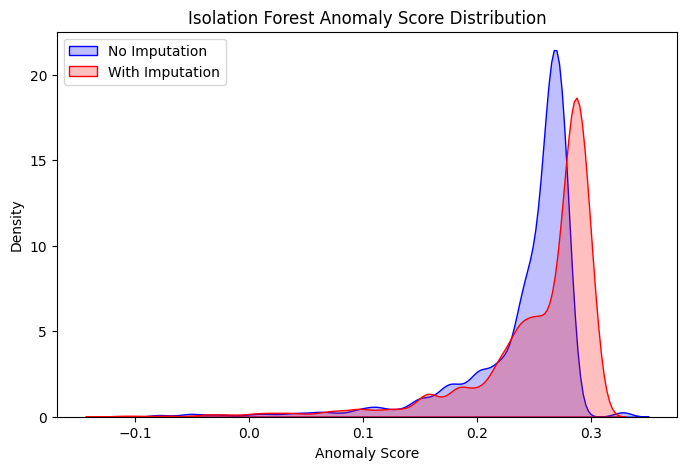

In [14]:
plt.figure(figsize=(8,5))
sns.kdeplot(scores_no_impute, label="No Imputation", fill=True, color="blue")
sns.kdeplot(scores_impute, label="With Imputation", fill=True, color="red")

plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.title("Isolation Forest Anomaly Score Distribution")
plt.legend()
plt.show()

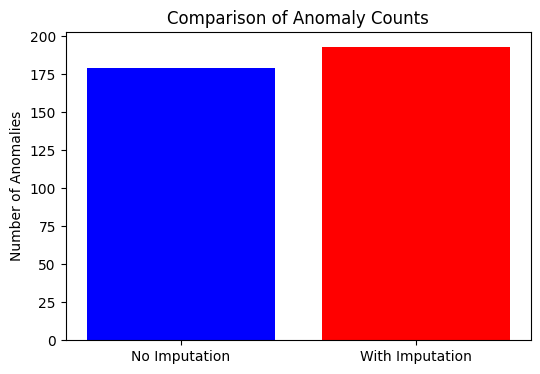

In [16]:
num_anomalies_no_impute = np.sum(anomalies_no_impute == -1)
num_anomalies_impute = np.sum(anomalies_impute == -1)

# Bar plot for number of detected anomalies
plt.figure(figsize=(6,4))
plt.bar(["No Imputation", "With Imputation"], [num_anomalies_no_impute, num_anomalies_impute], color=["blue", "red"])
plt.ylabel("Number of Anomalies")
plt.title("Comparison of Anomaly Counts")
plt.show()

In [22]:
### GMM ###
# Drop rows with missing flux values
df_no_impute_clean = df_no_impute.dropna(subset=['pdcsap_flux'])
X_no_impute_clean = df_no_impute_clean[['pdcsap_flux']].values
X_scaled_no_impute_clean = StandardScaler().fit_transform(X_no_impute_clean)

clusters_no_impute = gmm_no_impute.predict(X_scaled_no_impute_clean)
clusters_impute = gmm_impute.predict(X_scaled_impute)

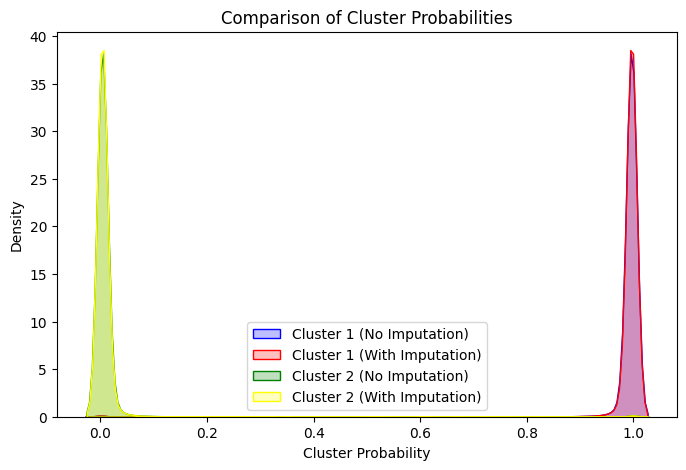

In [31]:
# Get probability distributions
probs_no_impute = gmm_no_impute.predict_proba(X_scaled_no_impute_clean)
probs_impute = gmm_impute.predict_proba(X_scaled_impute)

# Plot density comparison for first cluster
plt.figure(figsize=(8,5))
sns.kdeplot(probs_no_impute[:, 0], label="Cluster 1 (No Imputation)", fill=True, color="blue")
sns.kdeplot(probs_impute[:, 0], label="Cluster 1 (With Imputation)", fill=True, color="red")
sns.kdeplot(probs_no_impute[:, 1], label="Cluster 2 (No Imputation)", fill=True, color="green")
sns.kdeplot(probs_impute[:, 1], label="Cluster 2 (With Imputation)", fill=True, color="yellow")

plt.xlabel("Cluster Probability")
plt.ylabel("Density")
plt.title("Comparison of Cluster Probabilities")
plt.legend()
plt.show()
